In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.datasets import mnist, fashion_mnist, cifar10
from IPython.display import SVG
from keras.utils import model_to_dot

In [79]:
def show_model(model):
    if not COLAB:
        display(SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg')))

In [80]:
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()

In [81]:
X_tr.shape, X_te.shape

((60000, 28, 28), (10000, 28, 28))

In [82]:
X_tr.min(), X_tr.max()

(0, 255)

In [83]:
X_tr = X_tr / 255
X_te = X_te / 255

In [84]:
X_tr.min(), X_tr.max()

(0.0, 1.0)

In [85]:
np.unique(y_tr), np.unique(y_te)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

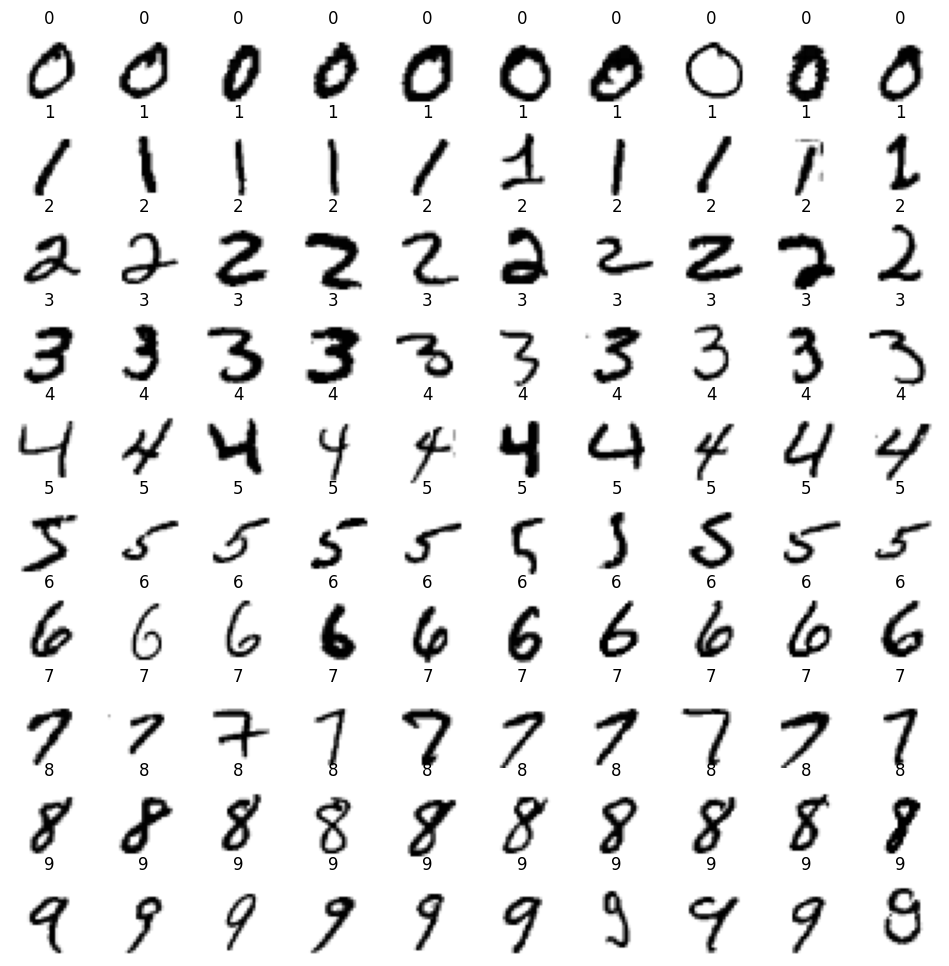

In [86]:
plt.figure(figsize=(12,12))
cont = 1
for clase in range(10):
  inds = np.where(y_tr==clase)[0]
  for ind in inds[:10]:
    plt.subplot(10,10,cont)
    plt.imshow(X_tr[ind], cmap="binary")
    plt.axis("off")
    plt.title(str(y_tr[ind]))
    cont = cont + 1

In [87]:
X_tr2 = X_tr[y_tr == 0] # Me quedo solo con los ceros

X_te_ceros = X_te[y_te==0]
X_te_unos  = X_te[y_te==1]

X_te2 = np.vstack((X_te_ceros, X_te_unos[:10]))
y_te2 = len(X_te_ceros)*[0] + 10*[1]
y_te2 = np.array(y_te2)

In [88]:
X_tr2.shape

(5923, 28, 28)

In [89]:
X_te2.shape

(990, 28, 28)

# Autoencoder lineal

In [90]:
from sklearn.decomposition import PCA

def encoder(X):
  return pca.transform(X) # comprime datos
def decoder(X):
  return pca.inverse_transform(X) # descomprime datos

In [91]:
X_tr2.shape

(5923, 28, 28)

In [92]:
X_tr2_flatten = X_tr2.reshape((len(X_tr2), -1))
X_tr2_flatten.shape

(5923, 784)

In [93]:
X_te2_flatten = X_te2.reshape((len(X_te2), -1))
X_te2_flatten.shape

(990, 784)

In [94]:
pca = PCA(n_components=30)
pca.fit(X_tr2_flatten)

PCA(n_components=30)

In [95]:
salida_ae_test = decoder(encoder(X_te2_flatten))
salida_ae_test.shape

(990, 784)

In [96]:
X_te2_flatten.shape

(990, 784)

In [97]:
score_anomalia = ((salida_ae_test - X_te2_flatten)**2).mean(axis=1)
score_anomalia.shape

(990,)

In [98]:
df_res = pd.DataFrame({"score":score_anomalia, "clase":y_te2})
df_res.sort_values("score", ascending=False)[:20]

score  clase
988  0.048716      1
353  0.044828      0
985  0.036412      1
982  0.035283      1
653  0.034987      0
63   0.034671      0
983  0.034455      1
137  0.033345      0
478  0.032272      0
986  0.031299      1
984  0.031044      1
376  0.030668      0
942  0.030114      0
981  0.029914      1
77   0.027225      0
621  0.026911      0
398  0.026886      0
408  0.026864      0
306  0.026833      0
312  0.026773      0

In [99]:
def plot_image(image, cmap="binary"):
    plt.imshow(image, cmap=cmap)
    plt.axis("off")

In [100]:
inds = df_res.sort_values("score", ascending=False)[:20].index.tolist()
inds

[988,
 353,
 985,
 982,
 653,
 63,
 983,
 137,
 478,
 986,
 984,
 376,
 942,
 981,
 77,
 621,
 398,
 408,
 306,
 312]

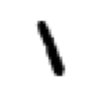

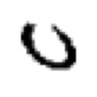

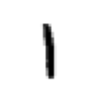

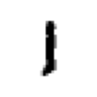

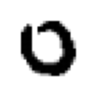

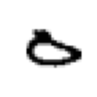

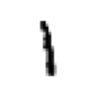

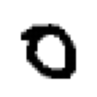

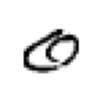

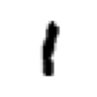

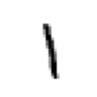

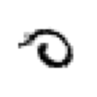

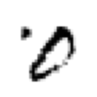

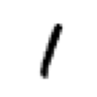

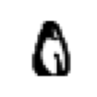

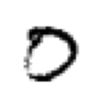

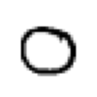

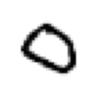

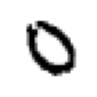

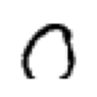

In [101]:
for ind in inds:
  plt.figure(figsize=(1,1))
  plot_image(X_te2[ind])
  plt.show()

# Autoencoder no lineal

In [102]:
import keras

In [103]:
model = keras.Sequential( [
    keras.Input((28,28)),
    keras.layers.Flatten(), # el flatten transforma la imagen en vector
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape((28, 28)) # transformo el vector en imagen
])

model.compile(optimizer="rmsprop", loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                39250     
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
 dense_6 (Dense)             (None, 50)                550       
                                                                 
 dense_7 (Dense)             (None, 784)               39984     
                                                                 
 reshape_1 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 80294 (313.65 KB)
Trainable params: 8029

In [104]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    keras.callbacks.ModelCheckpoint(filepath="best_model.keras",
                                    monitor="val_loss",
                                    save_best_only=True)
    ]

In [105]:
from sklearn.model_selection import train_test_split

X_tr2, X_val2 = train_test_split(X_tr2, test_size=0.3,
                                 random_state=1)

In [106]:
h = model.fit(X_tr2, X_tr2, batch_size=128, epochs=200, callbacks=callbacks,
              validation_data=(X_val2, X_val2))

Epoch 1/200
33/33 [==============================] - 2s 17ms/step - loss: 0.2059 - val_loss: 0.1178
Epoch 2/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0760 - val_loss: 0.0651
Epoch 3/200
33/33 [==============================] - 0s 11ms/step - loss: 0.0640 - val_loss: 0.0637
Epoch 4/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0629 - val_loss: 0.0626
Epoch 5/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0612 - val_loss: 0.0598
Epoch 6/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0576 - val_loss: 0.0555
Epoch 7/200
33/33 [==============================] - 0s 10ms/step - loss: 0.0539 - val_loss: 0.0529
Epoch 8/200
33/33 [==============================] - 0s 9ms/step - loss: 0.0522 - val_loss: 0.0520
Epoch 9/200
33/33 [==============================] - 0s 11ms/step - loss: 0.0511 - val_loss: 0.0509
Epoch 10/200
33/33 [==============================] - 0s 11ms/step - loss: 0.0499 - val_loss: 0.0493


In [107]:
h.history

{'loss': [0.20585066080093384,
  0.07600679993629456,
  0.06399073451757431,
  0.06292866170406342,
  0.06116855517029762,
  0.0575692355632782,
  0.05388801172375679,
  0.05216486006975174,
  0.05113484337925911,
  0.049880314618349075,
  0.04782424867153168,
  0.04559693858027458,
  0.044036880135536194,
  0.043186865746974945,
  0.04273167997598648,
  0.04245174303650856,
  0.04219711199402809,
  0.04196074977517128,
  0.041721124202013016,
  0.04152888059616089,
  0.041341207921504974,
  0.041116729378700256,
  0.040870435535907745,
  0.0406653992831707,
  0.04043000563979149,
  0.0402161106467247,
  0.04001205414533615,
  0.0398189052939415,
  0.03961004689335823,
  0.03942655771970749,
  0.039205845445394516,
  0.03903781995177269,
  0.03880554437637329,
  0.038596611469984055,
  0.038305096328258514,
  0.037996646016836166,
  0.037664156407117844,
  0.03720277547836304,
  0.03672318160533905,
  0.03617066890001297,
  0.035659052431583405,
  0.03514271229505539,
  0.0346653833985

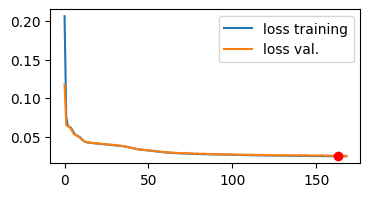

In [108]:
f = plt.figure(figsize=(4,2))
mejor_epoca = np.argmin(h.history["val_loss"]) # época (contando de 0) con menor val_loss
plt.plot(h.history["loss"], label="loss training")
plt.plot(h.history["val_loss"], label="loss val.")
plt.plot(mejor_epoca, h.history["val_loss"][mejor_epoca], "or")
plt.legend();

In [109]:
model = keras.models.load_model("best_model.keras") # mejor modelo, grabado a fichero

In [110]:
salida_ae_test2 = model.predict(X_te2)
salida_ae_test2.shape

31/31 [==============================] - 0s 3ms/step


(990, 28, 28)

In [111]:
score_anomalia2 = ((salida_ae_test2 - X_te2)**2).mean(axis=1).mean(axis=1)
score_anomalia2.shape

(990,)

In [120]:
df_res2 = pd.DataFrame({"score":score_anomalia2, "clase":y_te2})
df_res2 = df_res2.sort_values("score", ascending=False)[:20]
df_res2

score  clase
376  0.114872      0
984  0.096257      1
988  0.094612      1
987  0.093608      1
989  0.089858      1
985  0.088923      1
983  0.087598      1
980  0.086051      1
981  0.085312      1
526  0.083308      0
982  0.082722      1
63   0.080248      0
942  0.080066      0
353  0.079873      0
524  0.072198      0
986  0.071091      1
539  0.069571      0
553  0.068333      0
312  0.067723      0
449  0.066974      0

In [121]:
inds = df_res2.sort_values("score", ascending=False).index.tolist()
inds

[376,
 984,
 988,
 987,
 989,
 985,
 983,
 980,
 981,
 526,
 982,
 63,
 942,
 353,
 524,
 986,
 539,
 553,
 312,
 449]

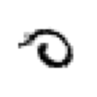

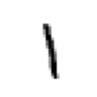

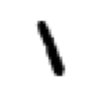

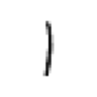

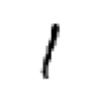

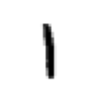

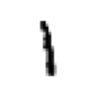

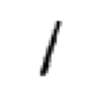

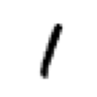

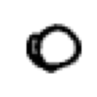

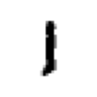

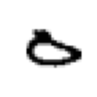

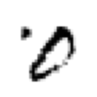

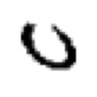

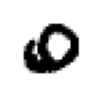

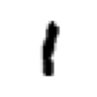

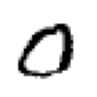

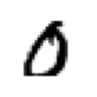

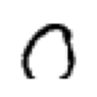

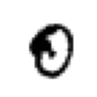

In [122]:
for ind in inds:
  plt.figure(figsize=(1,1))
  plot_image(X_te2[ind])
  plt.show()

In [123]:
salida_ae_test2[0].shape

(28, 28)

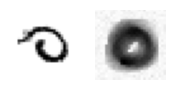

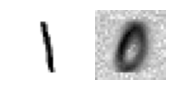

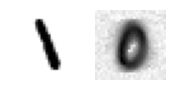

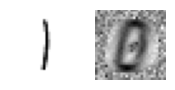

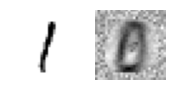

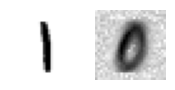

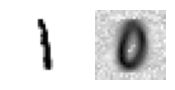

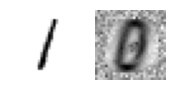

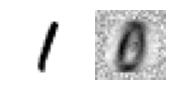

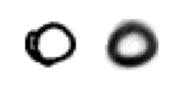

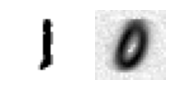

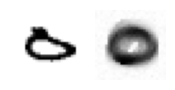

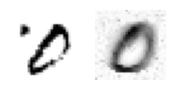

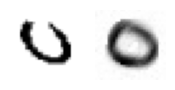

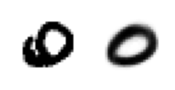

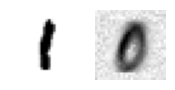

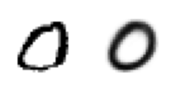

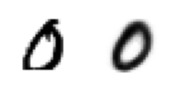

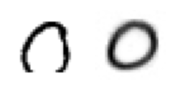

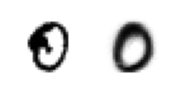

In [124]:
# enfrento las entradas al AE con sus salidas, para los ejemplos
# de test más anómalos:

for ind in inds:
  plt.figure(figsize=(2,1))
  plt.subplot(1,2,1)
  plot_image(X_te2[ind])
  plt.subplot(1,2,2)
  plot_image(salida_ae_test2[ind])
  plt.show()

In [125]:
error = salida_ae_test2 - X_te2

In [126]:
def show_error(X_error):
  img = np.zeros((28,28,3))
  img[:,:,1] = np.clip(X_error,0,1)
  img[:,:,2] = img[:,:,1]

  img[:,:,0] = -np.clip(X_error,-1,0)
  img[:,:,1] = img[:,:,1] + img[:,:,0]
  plt.imshow(1-img**2, vmin=0, vmax=1)
  plt.axis("off")

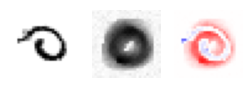

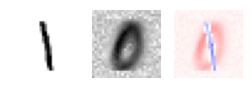

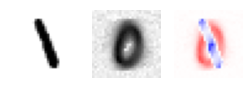

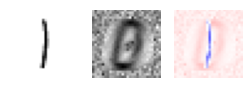

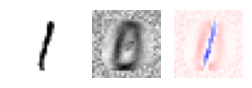

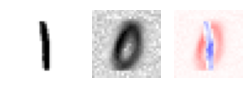

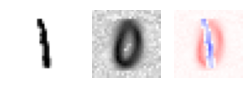

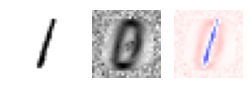

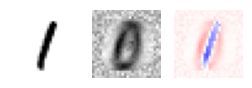

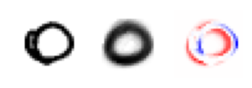

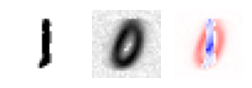

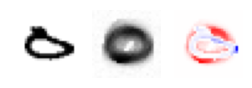

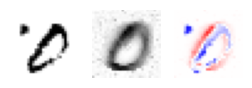

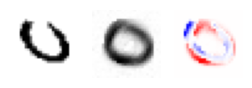

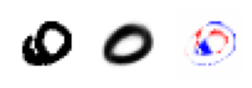

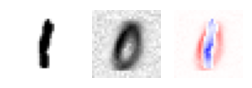

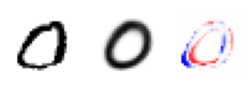

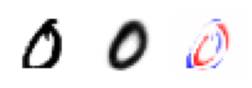

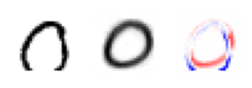

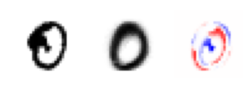

In [127]:
for ind in inds:
  plt.figure(figsize=(3,1))
  plt.subplot(1,3,1)
  plot_image(X_te2[ind])
  plt.subplot(1,3,2)
  plot_image(salida_ae_test2[ind])
  plt.subplot(1,3,3)
  show_error(error[ind])
  plt.show()